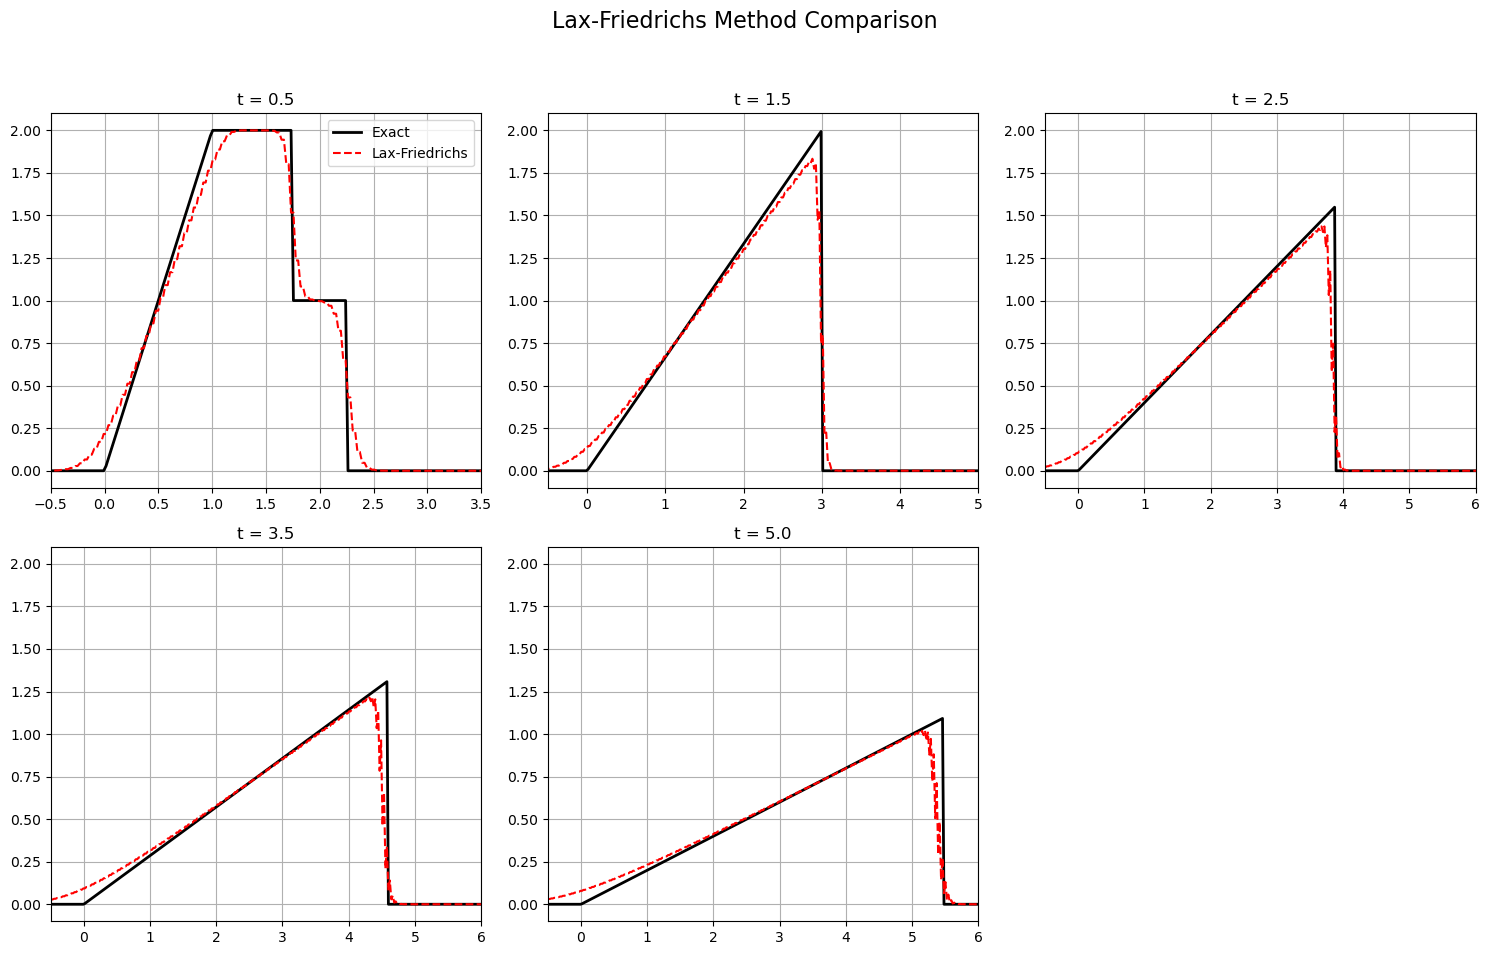

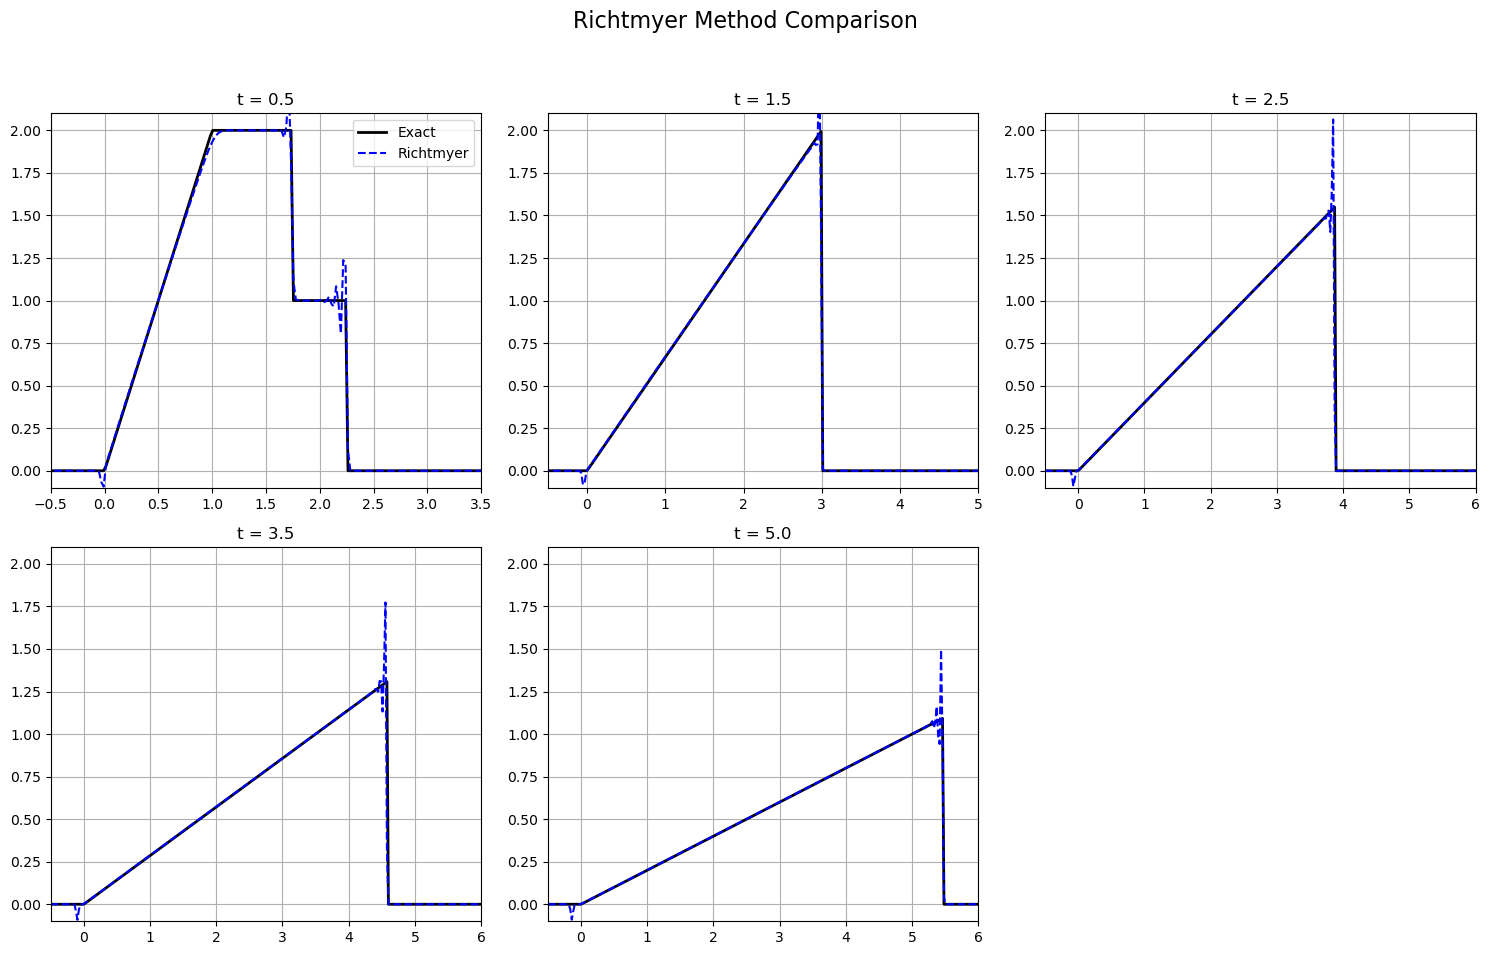

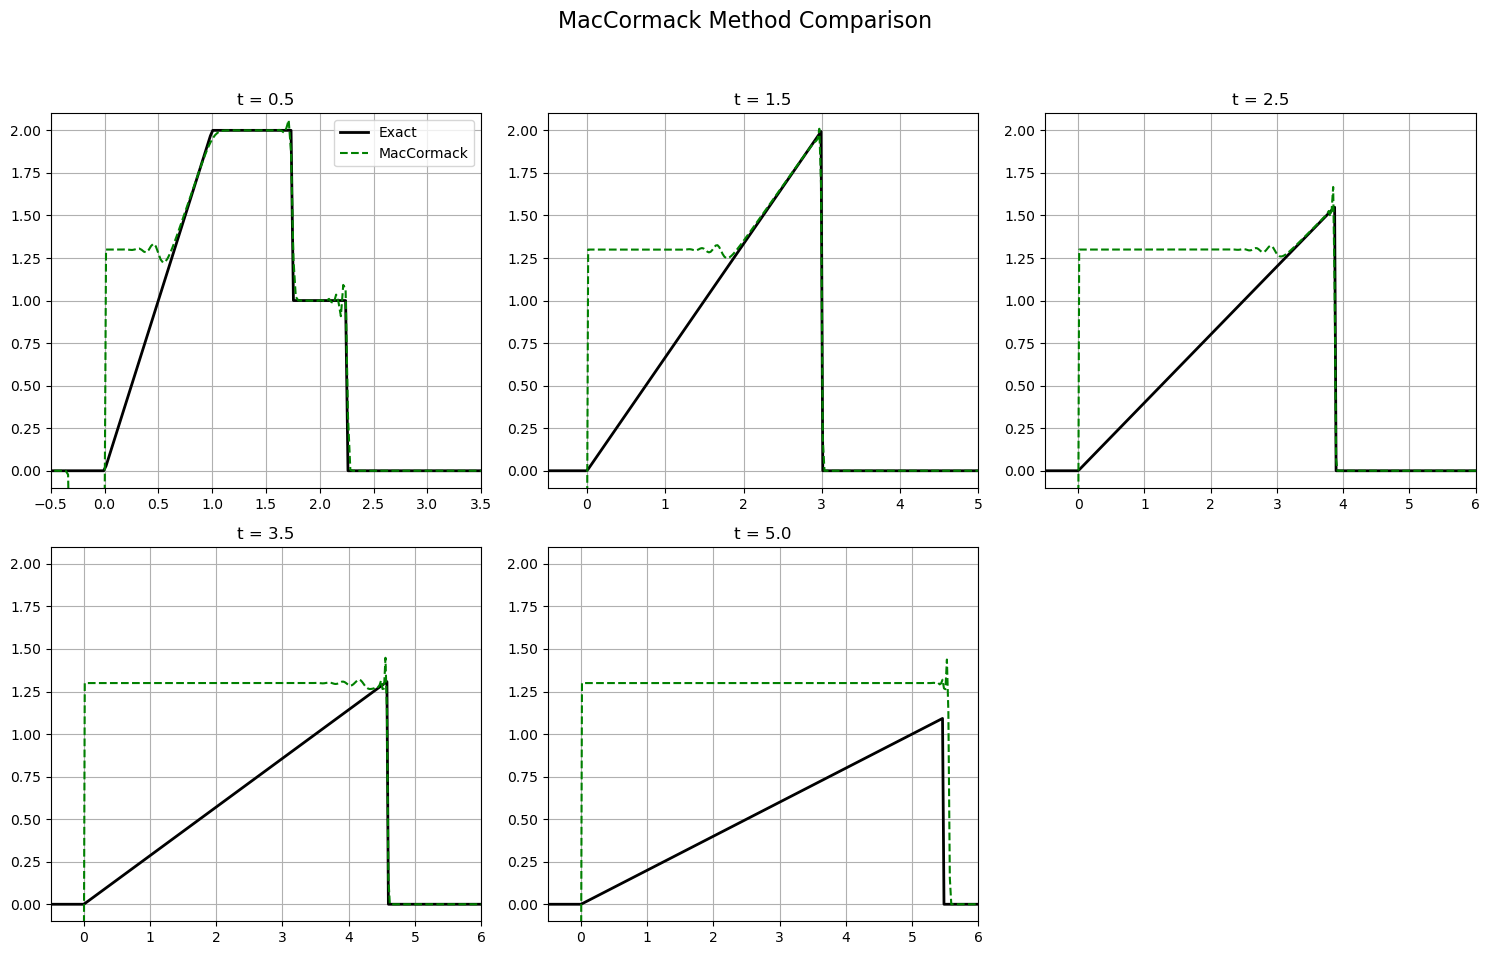

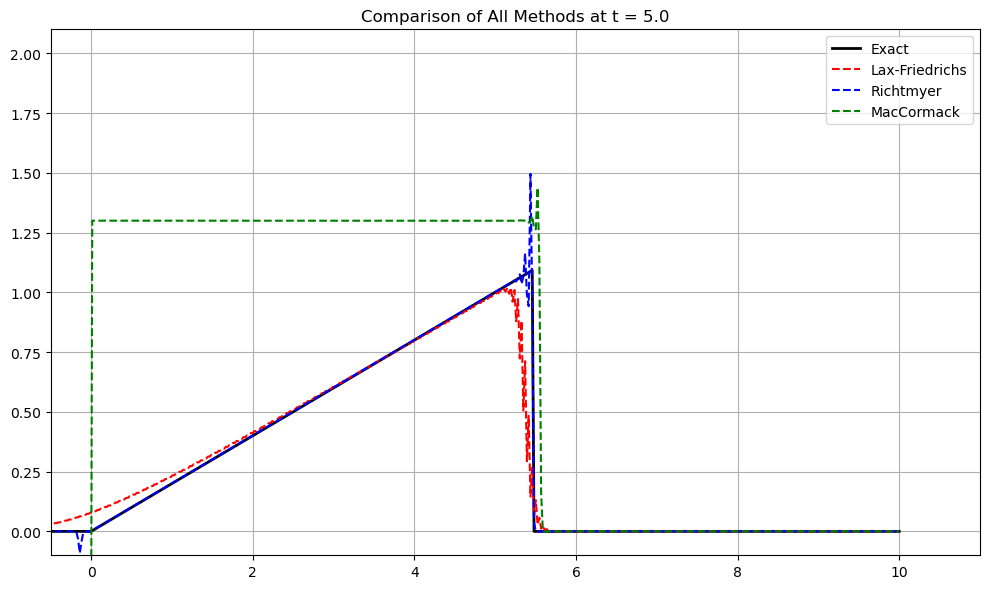

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def flux(u):
    return 0.5 * u**2

def initial_condition(x):
    u0 = np.zeros_like(x)
    u0[(x > 0) & (x <= 1)] = 2
    u0[(x > 1) & (x <= 2)] = 1
    return u0

def exact_solution(x, t):
    u = np.zeros_like(x)
    if t < 1.0:
        for i in range(len(x)):
            xi = x[i]
            if xi < 0:
                u[i] = 0
            elif xi < 2*t:
                u[i] = xi / t
            elif xi < 1 + 1.5*t:
                u[i] = 2
            elif xi < 2 + 0.5*t:
                u[i] = 1
            else:
                u[i] = 0
        return u
    elif t < 1.5:
        for i in range(len(x)):
            xi = x[i]
            if xi < 0:
                u[i] = 0
            elif xi < 2*t:
                u[i] = xi / t
            elif xi < 1.5 + t:
                u[i] = 2
            else:
                u[i] = 0
    else:
        for i in range(len(x)):
            xi = x[i]
            if xi < 0:
                u[i] = 0
            elif xi < np.sqrt(6*t):
                u[i] = xi / t
            else:
                u[i] = 0
    return u

def lax_friedrichs(u, dx, dt):
    u_new = np.zeros_like(u)
    r = dt/dx
    for j in range(1, len(u)-1):
        u_new[j] = 0.5 * (u[j+1] + u[j-1]) - 0.5 * r * (flux(u[j+1]) - flux(u[j-1]))
    u_new[0] = u_new[1]
    u_new[-1] = u_new[-2]
    return u_new

def richtmyer(u, dx, dt):
    u_new = np.zeros_like(u)
    r = dt/dx
    u_half = np.zeros(len(u))
    for j in range(len(u)-1):
        u_half[j] = 0.5 * (u[j] + u[j+1]) - 0.5 * r * (flux(u[j+1]) - flux(u[j]))
    for j in range(1, len(u)-1):
        u_new[j] = u[j] - r * (flux(u_half[j]) - flux(u_half[j-1]))
    u_new[0] = u_new[1]
    u_new[-1] = u_new[-2]
    return u_new

def maccormack(u, dx, dt):
    u_star = np.zeros_like(u)
    u_new = np.zeros_like(u)
    r = dt/dx
    for j in range(len(u)-1):
        u_star[j] = u[j] - r * (flux(u[j+1]) - flux(u[j]))
    u_star[-1] = u_star[-2]
    for j in range(1, len(u)):
        u_new[j] = 0.5 * (u[j] + u_star[j] - r * (flux(u_star[j]) - flux(u_star[j-1])))
    u_new[0] = u_new[1]
    return u_new

def solve_burgers_equation():
    x_min, x_max = -1, 10
    nx = 500
    dx = (x_max - x_min) / (nx - 1)
    x = np.linspace(x_min, x_max, nx)
    t_final = 5.0
    dt = 0.8 * dx / 2.0
    nt = int(t_final / dt) + 1
    target_times = [0.5, 1.5, 2.5, 3.5, 5.0]
    results = {t: {} for t in target_times}
    u_lf = initial_condition(x)
    u_richtmyer = initial_condition(x)
    u_maccormack = initial_condition(x)
    t = 0
    for n in range(nt):
        if abs(t - target_times[0]) < dt/2 or abs(t - target_times[1]) < dt/2 or \
           abs(t - target_times[2]) < dt/2 or abs(t - target_times[3]) < dt/2 or \
           abs(t - target_times[4]) < dt/2:
            # Store results at target times
            closest_target = min(target_times, key=lambda target: abs(t - target))
            if abs(t - closest_target) < dt/2:
                results[closest_target]['x'] = x
                results[closest_target]['lf'] = u_lf.copy()
                results[closest_target]['richtmyer'] = u_richtmyer.copy()
                results[closest_target]['maccormack'] = u_maccormack.copy()
                results[closest_target]['exact'] = exact_solution(x, closest_target)
        u_lf = lax_friedrichs(u_lf, dx, dt)
        u_richtmyer = richtmyer(u_richtmyer, dx, dt)
        u_maccormack = maccormack(u_maccormack, dx, dt)
        t += dt
    plot_results(results, target_times)

def plot_results(results, target_times):
    # Create figures for each method comparison
    fig1 = plt.figure(figsize=(15, 10))
    gs = GridSpec(2, 3, figure=fig1)
    ax1 = fig1.add_subplot(gs[0, 0])
    ax1.plot(results[0.5]['x'], results[0.5]['exact'], 'k-', linewidth=2, label='Exact')
    ax1.plot(results[0.5]['x'], results[0.5]['lf'], 'r--', label='Lax-Friedrichs')
    ax1.set_title(f't = 0.5')
    ax1.set_xlim(-0.5, 3.5)
    ax1.set_ylim(-0.1, 2.1)
    ax1.legend()
    ax1.grid(True)
    ax2 = fig1.add_subplot(gs[0, 1])
    ax2.plot(results[1.5]['x'], results[1.5]['exact'], 'k-', linewidth=2, label='Exact')
    ax2.plot(results[1.5]['x'], results[1.5]['lf'], 'r--', label='Lax-Friedrichs')
    ax2.set_title(f't = 1.5')
    ax2.set_xlim(-0.5, 5.0)
    ax2.set_ylim(-0.1, 2.1)
    ax2.grid(True)
    ax3 = fig1.add_subplot(gs[0, 2])
    ax3.plot(results[2.5]['x'], results[2.5]['exact'], 'k-', linewidth=2, label='Exact')
    ax3.plot(results[2.5]['x'], results[2.5]['lf'], 'r--', label='Lax-Friedrichs')
    ax3.set_title(f't = 2.5')
    ax3.set_xlim(-0.5, 6.0)
    ax3.set_ylim(-0.1, 2.1)
    ax3.grid(True)
    ax4 = fig1.add_subplot(gs[1, 0])
    ax4.plot(results[3.5]['x'], results[3.5]['exact'], 'k-', linewidth=2, label='Exact')
    ax4.plot(results[3.5]['x'], results[3.5]['lf'], 'r--', label='Lax-Friedrichs')
    ax4.set_title(f't = 3.5')
    ax4.set_xlim(-0.5, 6.0)
    ax4.set_ylim(-0.1, 2.1)
    ax4.grid(True)
    ax5 = fig1.add_subplot(gs[1, 1])
    ax5.plot(results[5.0]['x'], results[5.0]['exact'], 'k-', linewidth=2, label='Exact')
    ax5.plot(results[5.0]['x'], results[5.0]['lf'], 'r--', label='Lax-Friedrichs')
    ax5.set_title(f't = 5.0')
    ax5.set_xlim(-0.5, 6.0)
    ax5.set_ylim(-0.1, 2.1)
    ax5.grid(True)
    fig1.suptitle('Lax-Friedrichs Method Comparison', fontsize=16)
    fig1.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig2 = plt.figure(figsize=(15, 10))
    gs = GridSpec(2, 3, figure=fig2)
    ax1 = fig2.add_subplot(gs[0, 0])
    ax1.plot(results[0.5]['x'], results[0.5]['exact'], 'k-', linewidth=2, label='Exact')
    ax1.plot(results[0.5]['x'], results[0.5]['richtmyer'], 'b--', label='Richtmyer')
    ax1.set_title(f't = 0.5')
    ax1.set_xlim(-0.5, 3.5)
    ax1.set_ylim(-0.1, 2.1)
    ax1.legend()
    ax1.grid(True)
    ax2 = fig2.add_subplot(gs[0, 1])
    ax2.plot(results[1.5]['x'], results[1.5]['exact'], 'k-', linewidth=2, label='Exact')
    ax2.plot(results[1.5]['x'], results[1.5]['richtmyer'], 'b--', label='Richtmyer')
    ax2.set_title(f't = 1.5')
    ax2.set_xlim(-0.5, 5.0)
    ax2.set_ylim(-0.1, 2.1)
    ax2.grid(True)
    ax3 = fig2.add_subplot(gs[0, 2])
    ax3.plot(results[2.5]['x'], results[2.5]['exact'], 'k-', linewidth=2, label='Exact')
    ax3.plot(results[2.5]['x'], results[2.5]['richtmyer'], 'b--', label='Richtmyer')
    ax3.set_title(f't = 2.5')
    ax3.set_xlim(-0.5, 6.0)
    ax3.set_ylim(-0.1, 2.1)
    ax3.grid(True)
    ax4 = fig2.add_subplot(gs[1, 0])
    ax4.plot(results[3.5]['x'], results[3.5]['exact'], 'k-', linewidth=2, label='Exact')
    ax4.plot(results[3.5]['x'], results[3.5]['richtmyer'], 'b--', label='Richtmyer')
    ax4.set_title(f't = 3.5')
    ax4.set_xlim(-0.5, 6.0)
    ax4.set_ylim(-0.1, 2.1)
    ax4.grid(True)
    ax5 = fig2.add_subplot(gs[1, 1])
    ax5.plot(results[5.0]['x'], results[5.0]['exact'], 'k-', linewidth=2, label='Exact')
    ax5.plot(results[5.0]['x'], results[5.0]['richtmyer'], 'b--', label='Richtmyer')
    ax5.set_title(f't = 5.0')
    ax5.set_xlim(-0.5, 6.0)
    ax5.set_ylim(-0.1, 2.1)
    ax5.grid(True)
    fig2.suptitle('Richtmyer Method Comparison', fontsize=16)
    fig2.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig3 = plt.figure(figsize=(15, 10))
    gs = GridSpec(2, 3, figure=fig3)
    ax1 = fig3.add_subplot(gs[0, 0])
    ax1.plot(results[0.5]['x'], results[0.5]['exact'], 'k-', linewidth=2, label='Exact')
    ax1.plot(results[0.5]['x'], results[0.5]['maccormack'], 'g--', label='MacCormack')
    ax1.set_title(f't = 0.5')
    ax1.set_xlim(-0.5, 3.5)
    ax1.set_ylim(-0.1, 2.1)
    ax1.legend()
    ax1.grid(True)
    ax2 = fig3.add_subplot(gs[0, 1])
    ax2.plot(results[1.5]['x'], results[1.5]['exact'], 'k-', linewidth=2, label='Exact')
    ax2.plot(results[1.5]['x'], results[1.5]['maccormack'], 'g--', label='MacCormack')
    ax2.set_title(f't = 1.5')
    ax2.set_xlim(-0.5, 5.0)
    ax2.set_ylim(-0.1, 2.1)
    ax2.grid(True)
    ax3 = fig3.add_subplot(gs[0, 2])
    ax3.plot(results[2.5]['x'], results[2.5]['exact'], 'k-', linewidth=2, label='Exact')
    ax3.plot(results[2.5]['x'], results[2.5]['maccormack'], 'g--', label='MacCormack')
    ax3.set_title(f't = 2.5')
    ax3.set_xlim(-0.5, 6.0)
    ax3.set_ylim(-0.1, 2.1)
    ax3.grid(True)
    ax4 = fig3.add_subplot(gs[1, 0])
    ax4.plot(results[3.5]['x'], results[3.5]['exact'], 'k-', linewidth=2, label='Exact')
    ax4.plot(results[3.5]['x'], results[3.5]['maccormack'], 'g--', label='MacCormack')
    ax4.set_title(f't = 3.5')
    ax4.set_xlim(-0.5, 6.0)
    ax4.set_ylim(-0.1, 2.1)
    ax4.grid(True)
    ax5 = fig3.add_subplot(gs[1, 1])
    ax5.plot(results[5.0]['x'], results[5.0]['exact'], 'k-', linewidth=2, label='Exact')
    ax5.plot(results[5.0]['x'], results[5.0]['maccormack'], 'g--', label='MacCormack')
    ax5.set_title(f't = 5.0')
    ax5.set_xlim(-0.5, 6.0)
    ax5.set_ylim(-0.1, 2.1)
    ax5.grid(True)
    fig3.suptitle('MacCormack Method Comparison', fontsize=16)
    fig3.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig4 = plt.figure(figsize=(10, 6))
    ax = fig4.add_subplot(111)
    ax.plot(results[5.0]['x'], results[5.0]['exact'], 'k-', linewidth=2, label='Exact')
    ax.plot(results[5.0]['x'], results[5.0]['lf'], 'r--', label='Lax-Friedrichs')
    ax.plot(results[5.0]['x'], results[5.0]['richtmyer'], 'b--', label='Richtmyer')
    ax.plot(results[5.0]['x'], results[5.0]['maccormack'], 'g--', label='MacCormack')
    ax.set_title('Comparison of All Methods at t = 5.0')
    ax.set_xlim(-0.5, 11.0)
    ax.set_ylim(-0.1, 2.1)
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    solve_burgers_equation()